# Instruction Model - Alpaca
## 학습 목표
1. Alpaca에 대해 알아본다.
2. Instruction tuning에 대해 알아본다.
3. Gradient Accumulation, Mixed Precision, Quantization을 통해 LLaMA를 직접 Instruction tuning 해본다.

**context**
1. Alpaca 활용하기
2. Alpaca dataset을 이용한 Instruction tuning

## [Alpaca](https://github.com/tatsu-lab/stanford_alpaca) 활용하기

> Alpaca

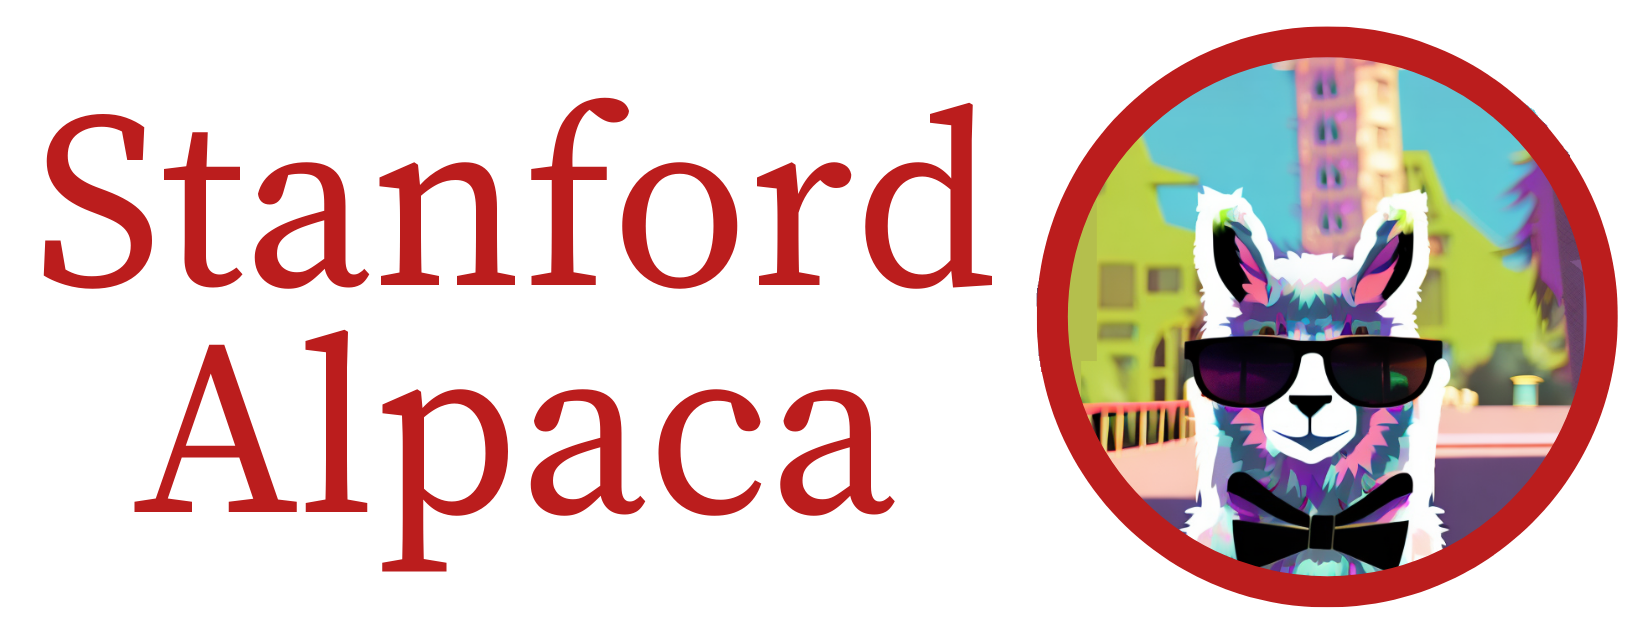

Alpaca는 LLaMA를 Stanford University에서 Instruction tuning한 모델을 의미한다.

Instruction dataset의 경우 [Self-Instruct](https://arxiv.org/abs/2212.10560) 방법론을 사용하여 구축하였으며, 해당 데이터를 [Alpaca dataset](https://raw.githubusercontent.com/tatsu-lab/stanford_alpaca/main/alpaca_data.json) 이라고 칭하기도 한다.

> Instruction tuning

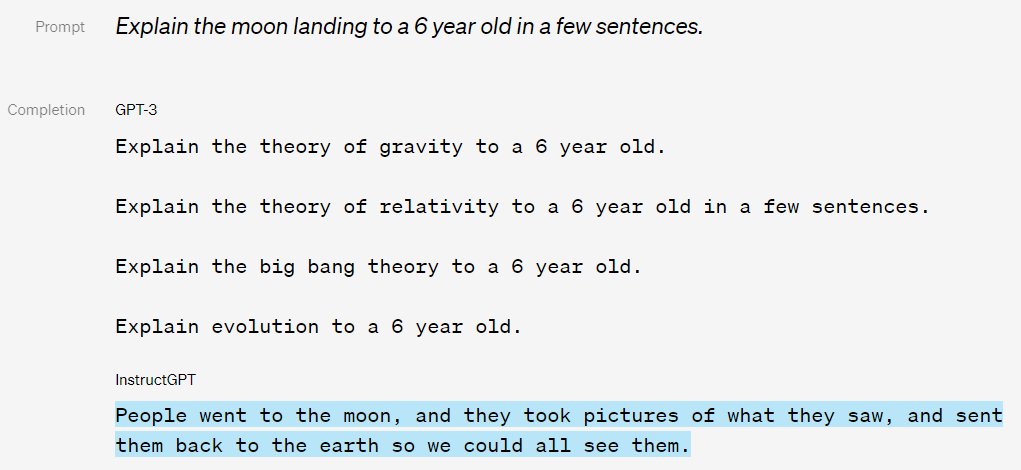

디코더 기반 언어모델의 경우, 사전학습 단계에서 다음 토큰을 예측하며 학습된다.

수많은 텍스트 데이터로 학습되기 때문에, 이것만으로 모델의 성능은 우수하지만, 인간의 명령 또는 의도에 따르도록 명시적으로 학습되지 않은 것이 한계라고 볼 수 있다.

따라서 Instruction이 포함된 데이터셋을 구축하고 이를 학습함으로써, 인간의 Instruction을 따르도록 하는 것이 Instruction tuning이다.

In [ ]:
! pip install transformers[torch] sentencepiece accelerate bitsandbytes peft datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.9/190.9 kB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 41.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.7 MB/s eta 0:00:00


In [ ]:
import torch
from transformers import LlamaTokenizer, AutoModelForCausalLM

tokenizer = LlamaTokenizer.from_pretrained("chavinlo/alpaca-native")
model = AutoModelForCausalLM.from_pretrained(
    "chavinlo/alpaca-native",
    torch_dtype=torch.float16,
    device_map="cuda:0",
).eval() # 모델을 평가 모드로 바꾼다.

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/335 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/96.0 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/556 [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

pytorch_model-00001-of-00003.bin:   0%|          | 0.00/9.88G [00:00<?, ?B/s]

pytorch_model-00002-of-00003.bin:   0%|          | 0.00/9.89G [00:00<?, ?B/s]

pytorch_model-00003-of-00003.bin:   0%|          | 0.00/7.18G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

In [ ]:
model.training # mode를 확인할 수 있다.

False

### Instruction을 활용한 번역

In [ ]:
PROMPT = """\
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
{instruction}

### Response:
"""

PROMPT_WITH_INPUT = """\
Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{instruction}

### Input:
{input_ctxt}

### Response:
"""

# 프롬프트를 생성하는 함수
def generate_prompt(instruction: str, input_ctxt: str = None, k=0) -> str:
    if input_ctxt:
        return PROMPT_WITH_INPUT.format(instruction=instruction, input_ctxt=input_ctxt)
    else:
        return PROMPT.format(instruction=instruction)

In [ ]:
prompt = generate_prompt("Translate English to German", "I like it")
print(prompt)

Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Translate English to German

### Input:
I like it

### Response:



In [ ]:
print(tokenizer.decode(
    model.generate(
        max_length=128, # 최대 128 토큰까지 생성한다.
        **tokenizer(prompt, return_tensors='pt').to(model.device),
    )[0],
    skip_special_tokens=True,
))

Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Translate English to German

### Input:
I like it

### Response:
Ich mag es.


### Instruction을 활용한 뉴스 제목 분류

> 실습 데이터 준비

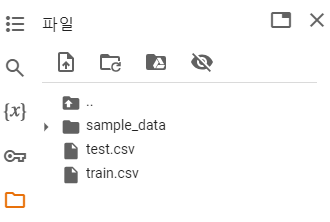

1. 좌측에 있는 파일 탭을 클릭한다.
2. data 폴더 내에 있는 train.csv와 test.csv를 드래그 & 드롭으로 업로드하거나, 업로드 버튼을 눌러 업로드한다.  

In [ ]:
PROMPT_WITH_INPUT_4shot = """\
Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{instruction}

### Input:
Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.

### Response:
business

### Input:
Comets, Asteroids and Planets around a Nearby Star (SPACE.com) SPACE.com - A nearby star thought to harbor comets and asteroids now appears to be home to planets, too. The presumed worlds are smaller than Jupiter and could be as tiny as Pluto, new observations suggest.

### Response:
science

### Input:
SI.com DETROIT (Ticker) -- A rocky first inning was too much for Denny Bautista to overcome in his first major league start. Craig Monroe had an RBI single in a three-run first inning and added a solo homer off Bautista

### Response:
sports

### Input:
Sudan Closes Its Embassy in Washington (AP) AP - Sudan said Wednesday it had closed its embassy in Washington after being unable to find a bank that would handle its financial matters.

### Response:
world

### Input:
{input_ctxt}

### Response:
"""

def generate_prompt(instruction: str, input_ctxt: str = None) -> str:
    return PROMPT_WITH_INPUT_4shot.format(instruction=instruction, input_ctxt=input_ctxt)

In [ ]:
from datasets import load_dataset, Dataset

LABEL = ["world", "sports", "business", "science"]

dataset = load_dataset("csv", data_files={"train": "train.csv", "test": "test.csv"})

print(dataset)
print(dataset['test'][0])

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 7600
    })
})
{'label': 2, 'text': "Fears for T N pension after talks Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul."}


In [ ]:
SAMPLE = dataset['test'][0]
print("Target-Label:", LABEL[SAMPLE['label']])

# 앞서 정의한 generate_prompt 함수를 통해 prompt를 생성한다.
prompt = generate_prompt(
    instruction="Categorize the given news headlines into the following four categories: {%s}" % ", ".join(LABEL),
    input_ctxt=SAMPLE['text']
)
print(prompt)

Target-Label: business
Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Categorize the given news headlines into the following four categories: {world, sports, business, science}

### Input:
Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.

### Response:
business

### Input:
Comets, Asteroids and Planets around a Nearby Star (SPACE.com) SPACE.com - A nearby star thought to harbor comets and asteroids now appears to be home to planets, too. The presumed worlds are smaller than Jupiter and could be as tiny as Pluto, new observations suggest.

### Response:
science

### Input:
SI.com DETROIT (Ticker) -- A rocky first inning was too much for Denny Bautista to overcome in his first major league start. Craig Monroe had an RBI single in a three-run first inning and added a 

In [ ]:
print(tokenizer.decode(
    model.generate(
        max_new_tokens=5, # 5토큰까지만 추가로 생성한다.
        **tokenizer(prompt, return_tensors='pt').to(model.device),
    )[0],
    skip_special_tokens=True
))

Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Categorize the given news headlines into the following four categories: {world, sports, business, science}

### Input:
Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.

### Response:
business

### Input:
Comets, Asteroids and Planets around a Nearby Star (SPACE.com) SPACE.com - A nearby star thought to harbor comets and asteroids now appears to be home to planets, too. The presumed worlds are smaller than Jupiter and could be as tiny as Pluto, new observations suggest.

### Response:
science

### Input:
SI.com DETROIT (Ticker) -- A rocky first inning was too much for Denny Bautista to overcome in his first major league start. Craig Monroe had an RBI single in a three-run first inning and added a solo homer off Bautista

In [ ]:
label_ids = [tokenizer.encode(label, add_special_tokens=False)[0] for label in LABEL]
print(label_ids)
print(tokenizer.decode(label_ids, skip_special_tokens=True))

[3186, 14717, 5381, 10466]
world sports business science


In [ ]:
from functools import partial

# 앞서 정의한 generate_prompt 함수를 데이터셋에 적용하기 위해 전처리 함수를 정의한다.
def preprocess(sample, prompter):
    return tokenizer(prompter(sample), return_length=True)

# map 함수를 통해 dataset에 전처리 함수를 적용한다.
# partial은 새로운 함수를 만들 때 사용할 수 있는 함수로, 인자가 이미 채워져 있는 함수를 정의할 수 있다.
instructions = dataset['test'].map(
    partial(preprocess,
        prompter=partial(generate_prompt, "Categorize the given news headlines into the following four categories: {%s}" % ", ".join(LABEL))
    ),
    remove_columns=["text"]
)

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (570 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
print(instructions[0])

{'label': 2, 'input_ids': [2, 13866, 338, 385, 15278, 393, 16612, 263, 3414, 29892, 3300, 2859, 411, 385, 1881, 393, 8128, 4340, 3030, 29889, 14350, 263, 2933, 393, 7128, 2486, 1614, 2167, 278, 2009, 29889, 13, 13, 2277, 29937, 2799, 4080, 29901, 13, 29907, 20440, 675, 278, 2183, 9763, 2343, 9012, 964, 278, 1494, 3023, 13997, 29901, 426, 11526, 29892, 14717, 29892, 5381, 29892, 10466, 29913, 13, 13, 2277, 29937, 10567, 29901, 13, 29956, 497, 624, 29889, 350, 15451, 6015, 29893, 7437, 512, 517, 278, 6054, 313, 1123, 329, 414, 29897, 830, 329, 414, 448, 13899, 29899, 29879, 28257, 29892, 14406, 7103, 29915, 29879, 11988, 513, 1847, 29905, 4980, 310, 8494, 336, 29899, 29883, 948, 1199, 29892, 526, 8790, 7933, 1449, 29889, 13, 13, 2277, 29937, 13291, 29901, 13, 8262, 3335, 13, 13, 2277, 29937, 10567, 29901, 13, 1523, 1691, 29892, 10186, 1489, 4841, 322, 8402, 1691, 2820, 263, 26206, 1609, 7828, 313, 5550, 11538, 29889, 510, 29897, 10937, 11538, 29889, 510, 448, 319, 20810, 5810, 2714, 304,

In [ ]:
tokenizer.add_special_tokens({'pad_token': '[PAD]'}) # 배치화하여 추론하기 위해 PAD 토큰을 추가한다.
model.resize_token_embeddings(len(tokenizer)) # 토큰이 새롭게 추가되었기에, 임베딩 행렬의 크기를 재조정해야 한다.
tokenizer.padding_side = "right" # 패딩을 추가할 위치를 지정한다.

In [ ]:
import torch
from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding
from tqdm.notebook import tqdm

# 예시 배치 (batch size:2, length=128)
# ... Pennington Reaches Long-Term Deal with Jets  NEW YORK (Sports Network) - The New York Jets and  quarterback Chad Pennington finally agreed on a long-term  contract extension Wednesday. =>
# ... Fears for T N pension after talks Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul. => [PAD] [PAD] ...

def get_accuracy(model: AutoModelForCausalLM, dataset: Dataset, batch_size: int):
    collator = DataCollatorWithPadding(tokenizer) # DataColloatorWithPadding을 통해 배치화 시 패딩을 사용한다.
    loader = DataLoader(dataset, batch_size=batch_size, collate_fn=collator, shuffle=False)

    trues = 0

    for sample in tqdm(loader):
        sample = sample.to("cuda")
        lengths = sample.pop("length")
        labels = sample.pop("labels")

        with torch.inference_mode():
            outputs = model(**sample) # outputs.logits의 크기 : (batch_size, seq_len, vocab_size)
        logits = outputs.logits[torch.arange(len(lengths), device=lengths.device), lengths-1] # 마지막 토큰 자리의 representation을 추출한다. (batchsize, vocab_size)
        prediction = logits[..., label_ids] # 4개의 라벨의 token_id에 해당하는 로짓들을 추출한다. (batchsize, len(label_ids))
        prediction = prediction.argmax(-1) # 4개의 라벨 중 가장 큰 라벨을 예측값으로 선택한다. (batchsize)

        trues += (labels == prediction).sum().item() # 맞춘 개수를 누적합한다.

    return trues / len(dataset)

print("4-shot Accuracy:", get_accuracy(model, instructions, batch_size=2)) # 0.72

  0%|          | 0/3800 [00:00<?, ?it/s]

4-shot Accuracy: 0.7217105263157895


In [ ]:
# 지난 실습 2_LLaMA에서 get_accuracy 함수의 내부 구현에 대한 이해를 권장하였다. 적절히 이해하였는지 아래 코드의 출력을 통해 확인해 보자.

def get_accuracy(model: AutoModelForCausalLM, dataset: Dataset, batch_size: int):
    collator = DataCollatorWithPadding(tokenizer) # DataColloatorWithPadding을 통해 배치화 시 패딩을 사용한다.
    loader = DataLoader(dataset, batch_size=batch_size, collate_fn=collator, shuffle=False)

    trues = 0

    for sample in tqdm(loader):
        sample = sample.to("cuda")
        lengths = sample.pop("length")
        labels = sample.pop("labels")

        print("# sample['input_ids'].shape:", sample['input_ids'].shape)
        print("# sample['attention_mask'].shape:", sample['attention_mask'].shape)

        with torch.inference_mode():
            outputs = model(**sample)
        print("# outputs.logits.shape", outputs.logits.shape) # outputs.logits의 크기 : (batch_size, seq_len, vocab_size)
        logits = outputs.logits[torch.arange(len(lengths), device=lengths.device), lengths-1] # 마지막 토큰 자리의 representation을 추출한다. (batchsize, vocab_size)
        print("# logits.shape", logits.shape)
        prediction = logits[..., label_ids] # 4개의 라벨의 token_id에 해당하는 로짓들을 추출한다. (batchsize, len(label_ids))
        print("# prediction.shape", prediction.shape)
        prediction = prediction.argmax(-1) # 4개의 라벨 중 가장 큰 라벨을 예측값으로 선택한다. (batchsize)
        print("# prediction.shape", prediction.shape)

        break

print("4-shot Accuracy:", get_accuracy(model, instructions, batch_size=2))

  0%|          | 0/3800 [00:00<?, ?it/s]

# sample['input_ids'].shape: torch.Size([2, 467])
# sample['attention_mask'].shape: torch.Size([2, 467])
# outputs.logits.shape torch.Size([2, 467, 32001])
# logits.shape torch.Size([2, 32001])
# prediction.shape torch.Size([2, 4])
# prediction.shape torch.Size([2])
4-shot Accuracy: None


## Alpaca 학습하기

크기가 큰 언어 모델을 학습하기 위해 필요한 기법들을 터득해 보고 Pytorch와 SFTTrainer를 통해 Instruction tuning을 해보자.

* Out of Memory를 방지하기 위해 런타임을 삭제한 이후, 아래 셀부터 다시 실행할 것을 추천한다.
* 런타임-런타임 연결 해제 및 삭제

In [ ]:
! pip install transformers[torch] sentencepiece accelerate bitsandbytes peft datasets trl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 MB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.9/190.9 kB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 49.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 12.7 MB/s eta 0:00:00


In [ ]:
import torch
from transformers import LlamaTokenizer, AutoModelForCausalLM

tokenizer = LlamaTokenizer.from_pretrained("huggyllama/llama-7b", add_eos_token=True)
tokenizer.pad_token = tokenizer.eos_token
model = AutoModelForCausalLM.from_pretrained(
    "huggyllama/llama-7b",
    load_in_4bit=True, # bitsandbytes를 통해 4bit로 Quantization하여 모델을 불러온다.
    torch_dtype=torch.float16,
    device_map='cuda:0'
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/700 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/411 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/594 [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

### Alpaca dataset 준비
앞서 설명했듯이, Alpaca dataset은 Self-Instruct 기법을 통해 생성된 Instruction 데이터이다.

약 52000개의 데이터로 구성되어 있으며, OpenAI의 text-davinci-003 모델을 통하여 인공적으로 만들어진 데이터이다.

각 데이터는 4가지 features(instruction, input, output, text)로 이루어져 있다.

In [ ]:
from datasets import load_dataset, Dataset

dataset = load_dataset("tatsu-lab/alpaca")
print(dataset)

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['instruction', 'input', 'output', 'text'],
        num_rows: 52002
    })
})


In [ ]:
dataset = dataset['train'].remove_columns(['text'])

In [ ]:
# Instruction tuning에 사용할 Prompt format을 지정한다.
# Input이 없는 Prompt format
PROMPT = """\
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
{instruction}

### Response:
{output}"""

# Input이 있는 Prompt format
PROMPT_WITH_INPUT = """\
Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{instruction}

### Input:
{input}

### Response:
{output}"""

def generate_prompt(instruction: str, output: str, input: str = None) -> str:
    if input:
        return PROMPT_WITH_INPUT.format(instruction=instruction, output=output, input=input)
    else:
        return PROMPT.format(instruction=instruction, output=output)

In [ ]:
prompt = generate_prompt(**dataset[0])
print(prompt)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Give three tips for staying healthy.

### Response:
1.Eat a balanced diet and make sure to include plenty of fruits and vegetables. 
2. Exercise regularly to keep your body active and strong. 
3. Get enough sleep and maintain a consistent sleep schedule.


In [ ]:
# 데이터셋을 전처리하기 위한 function을 정의한다.
def preprocess(sample):
    prompt = generate_prompt(**sample) # 프롬프트 생성
    result = tokenizer(prompt) # 프롬프트 토큰화
    result["text"] = prompt # 토큰화 이전 프롬프트도 추가
    return result

instructions = dataset.map(
    preprocess,
    remove_columns=["instruction", "output", "input"],
)

Map:   0%|          | 0/52002 [00:00<?, ? examples/s]

In [ ]:
print(instructions)

Dataset({
    features: ['input_ids', 'attention_mask', 'text'],
    num_rows: 52002
})


In [ ]:
print(instructions[0])

{'input_ids': [1, 13866, 338, 385, 15278, 393, 16612, 263, 3414, 29889, 14350, 263, 2933, 393, 7128, 2486, 1614, 2167, 278, 2009, 29889, 13, 13, 2277, 29937, 2799, 4080, 29901, 13, 29954, 573, 2211, 25562, 363, 7952, 292, 9045, 29891, 29889, 13, 13, 2277, 29937, 13291, 29901, 13, 29896, 29889, 29923, 271, 263, 6411, 8362, 652, 300, 322, 1207, 1854, 304, 3160, 20947, 310, 285, 21211, 322, 18655, 1849, 29889, 29871, 13, 29906, 29889, 1222, 6269, 895, 25704, 304, 3013, 596, 3573, 6136, 322, 4549, 29889, 29871, 13, 29941, 29889, 3617, 3307, 8709, 322, 7344, 263, 13747, 8709, 20410, 29889, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'text': 'Below is an instruction that describes a task. Write a response that appropria

위 과정들을 하나의 함수로 구현해 보자. 구현한 함수를 아래에서 반복적으로 사용할 것이다.

In [ ]:
PROMPT = """\
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
{instruction}

### Response:
{output}"""

PROMPT_WITH_INPUT = """\
Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{instruction}

### Input:
{input}

### Response:
{output}"""

def create_dataset(dataset_name, dataset_len):
    def generate_prompt(instruction: str, output: str, input: str = None) -> str:
        if input:
            return PROMPT_WITH_INPUT.format(instruction=instruction, output=output, input=input)
        else:
            return PROMPT.format(instruction=instruction, output=output)

    def preprocess(sample):
        prompt = generate_prompt(**sample)
        result = tokenizer(prompt)
        result["text"] = prompt
        return result

    from datasets import load_dataset, Dataset
    dataset = load_dataset(dataset_name)
    dataset = dataset['train'].remove_columns(['text'])

    from transformers import LlamaTokenizer, AutoModelForCausalLM
    tokenizer = LlamaTokenizer.from_pretrained("huggyllama/llama-7b", add_eos_token=True)
    tokenizer.pad_token = tokenizer.eos_token

    instructions = dataset.map(
        preprocess,
        remove_columns=["instruction", "output", "input"],
    )

    small_instructions = instructions.select(range(dataset_len)) # 본 실습에선 실습의 원활성을 위해 데이터셋의 일부만 사용한다.
    return small_instructions

In [ ]:
dataset = create_dataset("tatsu-lab/alpaca", dataset_len=100)

Map:   0%|          | 0/52002 [00:00<?, ? examples/s]

In [ ]:
print(dataset[0])

{'input_ids': [1, 13866, 338, 385, 15278, 393, 16612, 263, 3414, 29889, 14350, 263, 2933, 393, 7128, 2486, 1614, 2167, 278, 2009, 29889, 13, 13, 2277, 29937, 2799, 4080, 29901, 13, 29954, 573, 2211, 25562, 363, 7952, 292, 9045, 29891, 29889, 13, 13, 2277, 29937, 13291, 29901, 13, 29896, 29889, 29923, 271, 263, 6411, 8362, 652, 300, 322, 1207, 1854, 304, 3160, 20947, 310, 285, 21211, 322, 18655, 1849, 29889, 29871, 13, 29906, 29889, 1222, 6269, 895, 25704, 304, 3013, 596, 3573, 6136, 322, 4549, 29889, 29871, 13, 29941, 29889, 3617, 3307, 8709, 322, 7344, 263, 13747, 8709, 20410, 29889, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'text': 'Below is an instruction that describes a task. Write a response that appropria

### LoRA 살펴보기

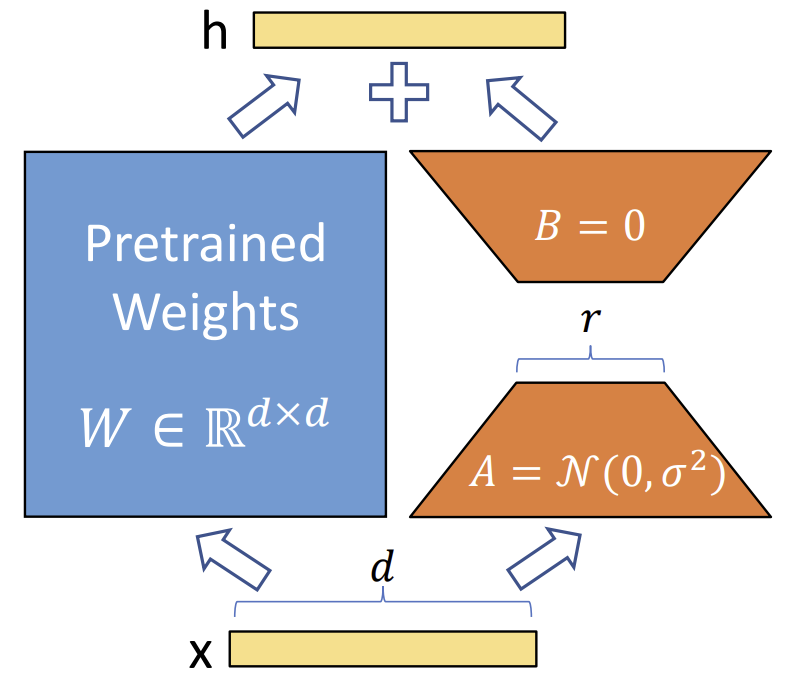

> Low-Rank Adaptation (LoRA)

LoRA는 큰 모델을 튜닝하기 위한 Parameter Efficient Fine Tuning (PEFT) 방법론 중 가장 널리 사용되는 방법론이다.

본 실습에서도 Instruction tuning 시에 LoRA를 사용할 것이며, 큰 모델을 직접 튜닝하는 상황에서 필수적이므로 반드시 숙지하도록 하자.

[참고자료](https://huggingface.co/docs/peft/v0.8.2/en/package_reference/lora#peft.LoraConfig)

In [ ]:
from peft import LoraConfig, TaskType, get_peft_model, prepare_model_for_kbit_training

print("--Before LoRA--")
print(model)
lora_model = prepare_model_for_kbit_training(model) # function to preprocess the quantized model for traininng.

# LoraConfig를 생성한다.
peft_config = LoraConfig(
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"], # LoRA가 적용될 모듈을 선택한다.
    lora_dropout=0.05, # LoRA에 적용할 드롭아웃을 설정한다.
    task_type=TaskType.CAUSAL_LM # Causal modeling을 위한 task type을 지정한다.
)

lora_model = get_peft_model(lora_model, peft_config) # function to create a PeftModel from the quantized model and configuration.
print("--After LoRA--")
print(lora_model)

--Before LoRA--
LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096, padding_idx=0)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear4bit(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
  

In [ ]:
# LoRA 이외의 다른 layer들은 freeze 되어있는 것을 알 수 있다.
for name, param in lora_model.named_parameters():
  if param.requires_grad:
    print(name)

base_model.model.model.layers.0.self_attn.q_proj.lora_A.default.weight
base_model.model.model.layers.0.self_attn.q_proj.lora_B.default.weight
base_model.model.model.layers.0.self_attn.k_proj.lora_A.default.weight
base_model.model.model.layers.0.self_attn.k_proj.lora_B.default.weight
base_model.model.model.layers.0.self_attn.v_proj.lora_A.default.weight
base_model.model.model.layers.0.self_attn.v_proj.lora_B.default.weight
base_model.model.model.layers.0.self_attn.o_proj.lora_A.default.weight
base_model.model.model.layers.0.self_attn.o_proj.lora_B.default.weight
base_model.model.model.layers.1.self_attn.q_proj.lora_A.default.weight
base_model.model.model.layers.1.self_attn.q_proj.lora_B.default.weight
base_model.model.model.layers.1.self_attn.k_proj.lora_A.default.weight
base_model.model.model.layers.1.self_attn.k_proj.lora_B.default.weight
base_model.model.model.layers.1.self_attn.v_proj.lora_A.default.weight
base_model.model.model.layers.1.self_attn.v_proj.lora_B.default.weight
base_m

### LLM을 학습하기 위한 기법들

LLM을 학습하는 것은 상당한 자원이 요구되는 작업이므로 LoRA 뿐만 아니라 효율적인 학습을 위한 다양한 기술들이 있다.

Gradient Accumulation, Mixed Precision Training, Packing에 대해 다루어보자.

#### Gradient Accumulation & Mixed Precision Training

> Gradient Accumulation

Gradient Accumulation이란, Gradient를 누적한 이후 한 번에 가중치를 업데이트하는 방법론이다.

학습에 사용하는 배치 크기가 128이라고 가정할 때, forward 시에 연산을 추적하는 과정에서 Out of Memory가 발생할 수 있다.

따라서, 배치 크기를 32로 설정한 이후, 4개의 배치에 대해 Gradient를 누적하고 한 번에 업데이트한다면 메모리 요구량이 줄어들 수 있다.

> Mixed Precision Training

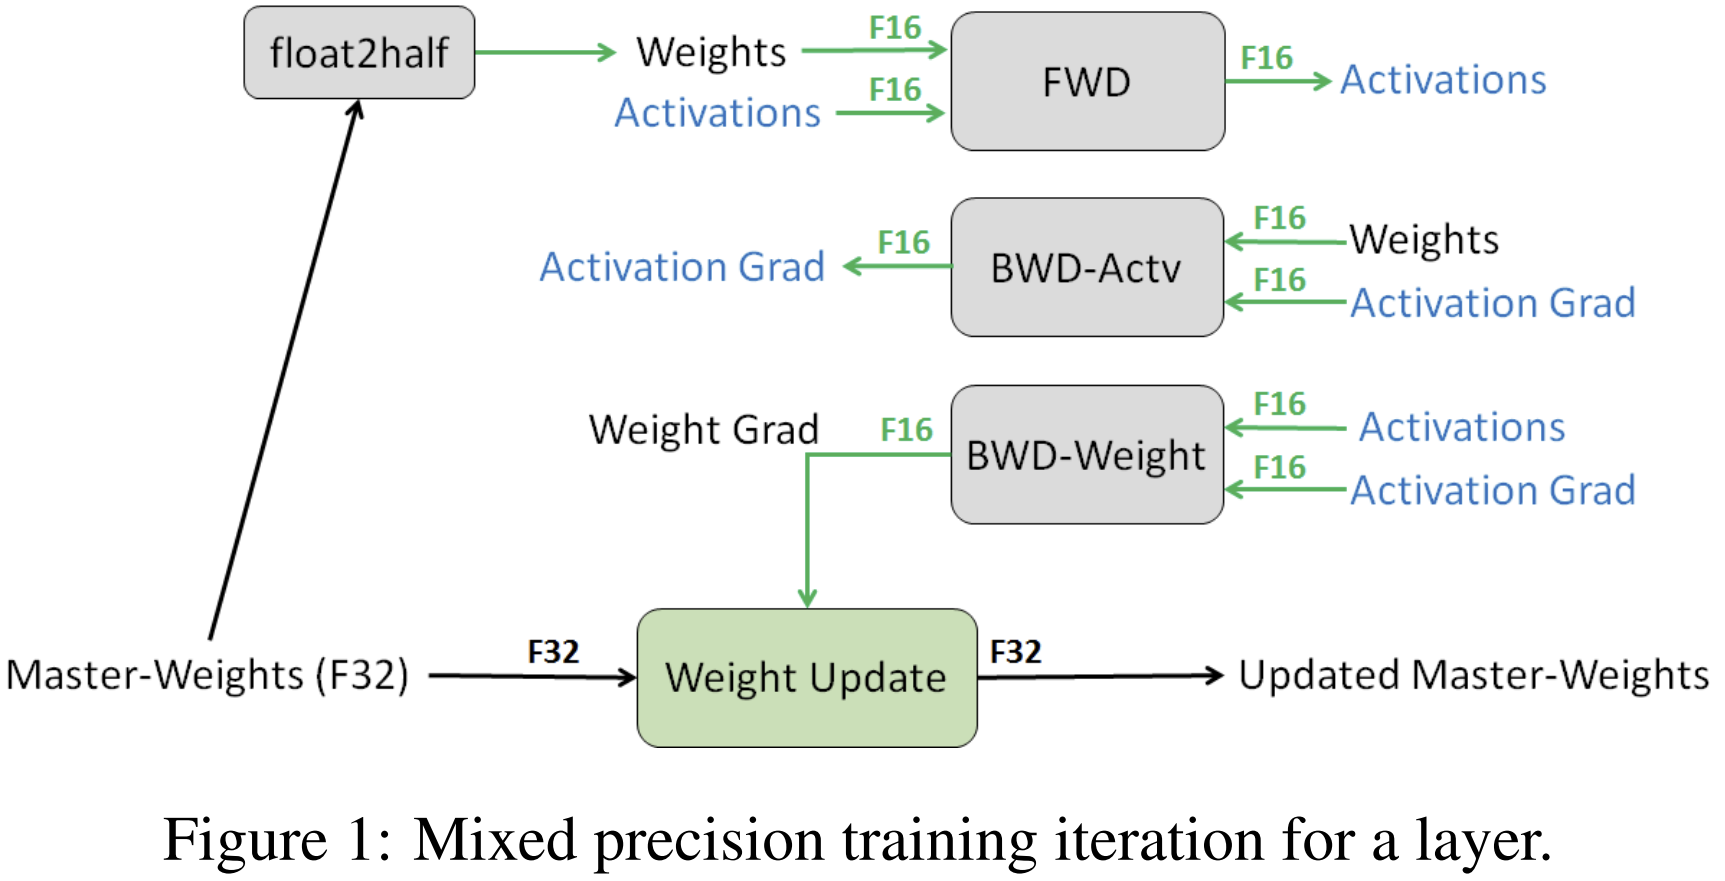

일반적으로 실수는 FP32, 즉 32bit로 정의된다.

모델의 크기가 점점 커지는 NLP 분야에선 효율성을 위해 FP32만을 사용하여 학습하지 않으며, 일반적으로 두 개의 데이터 타입을 동시에 활용하는 학습 방법인 Mixed Precision을 사용한다.

자세한 구현은 **Pytorch를 통한 Instruction tuning** 섹션에서 알아보자.

#### Packing

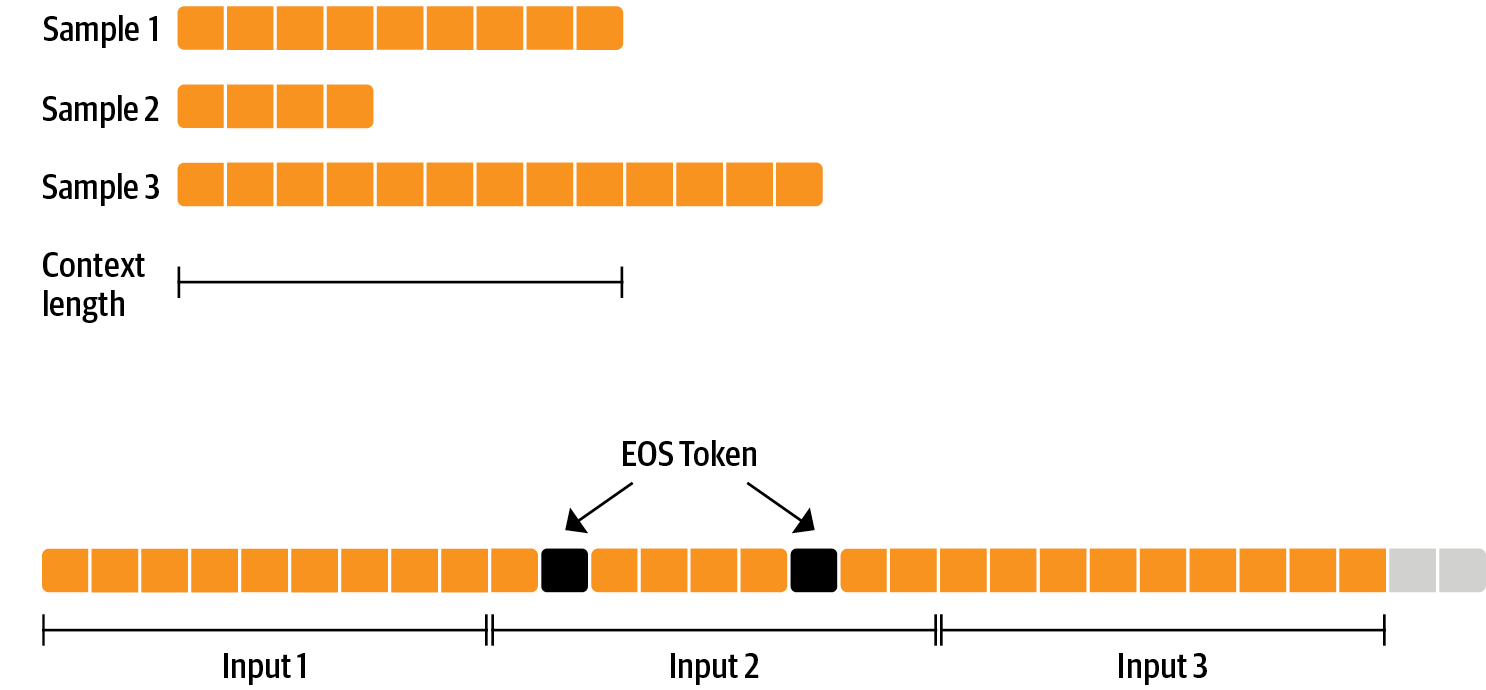

언어모델 학습에 사용하는 문장은 다양한 길이로 이루어져 있다.

이들을 배치화하여 학습하기 위해서는 Padding token을 사용해야 하는데, 이는 연산 낭비로 이어질 수 있다.

또한 대부분의 문장은 길이가 길지 않기 때문에 학습한 언어모델이 긴 문장을 모델링하는 데에 어려움을 겪을 수 있다.

이를 해결하기 위해 Packing(묶음) 기법이 등장하였다.

핵심 아이디어는 최대 길이까지 여러 문장을 묶는 것이며, 배치를 구성할 때 Padding token을 도입할 필요가 없게 된다. 이는 연산 낭비를 줄이며, 학습된 언어 모델 역시 긴 문장을 모델링할 수 있게 된다. 아래 예시를 통해 Packing을 이해해 보자.

---

Sequence1 : ["I", "love", "you"]

Sequence2 : ["I", "like", "playing", "soccer", "with", "my", "friend"]

> Padding을 통한 배치화

```
[["<s>", "I", "love", "you", "</s>", "<PAD>", "<PAD>", "<PAD>", "<PAD>"]
["<s>", "I", "like", "playing", "soccer", "with", "my", "friend", "</s>"]]
```

> Packing을 통한 문장 묶음

```
["<s>", "I", "love", "you", "</s>", "<s>", "I", "like", "playing", "soccer", "with", "my", "friend", "</s>"]
```




In [ ]:
from transformers import LlamaTokenizer
tokenizer = LlamaTokenizer.from_pretrained("huggyllama/llama-7b", add_eos_token=True)
tokenizer.pad_token = tokenizer.eos_token

In [ ]:
print(tokenizer.bos_token)
print(tokenizer.eos_token)

<s>
</s>


In [ ]:
encoded = tokenizer("Studying Deep Learning is happy!")
print("encoded:", encoded) # input_ids와 attention_mask로 이루어져 있다.

encoded: {'input_ids': [1, 5088, 5414, 21784, 29257, 338, 9796, 29991, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [ ]:
decoded = tokenizer.decode(encoded.input_ids)
print("decoded:", decoded)

decoded: <s> Studying Deep Learning is happy!</s>


In [ ]:
from itertools import chain

def packing(sequences, tokenizer, max_length=512):
    input_ids = [tokenizer(sequence).input_ids for sequence in sequences]
    concatenated_input_ids = list(chain.from_iterable(input_ids)) # 모든 input_id가 concat된다.

    concatenated_len = len(concatenated_input_ids)
    new_input_ids = list() # packing된 sequence들로 이루어져 있는 변수이다. 최종적으로 이 변수를 반환할 것이다.

    start_idx = 0 # 시작 인덱스
    while True:
        end_idx = start_idx + max_length # 끝 인덱스
        if end_idx > concatenated_len: # 유효한 길이를 초과하면 while문에서 탈출한다.
            break
        new_input_ids.append(concatenated_input_ids[start_idx:end_idx])
        start_idx = end_idx # start_idx를 초기화한다.

    new_attention_mask = [[1]*max_length for _ in range(len(new_input_ids))] # attention_mask도 새롭게 정의한다.
    return new_input_ids, new_attention_mask

In [ ]:
sequence1 = "I love you."
sequence2 = "I like playing soccer with my middle school friends."
sequence3 = "Artificial intelligence is trained with tons of data and can perform many tasks."
sequence4 = "Large language models do amazing things."
sequences = [sequence1, sequence2, sequence3, sequence4]

In [ ]:
new_input_ids, new_attention_mask = packing(sequences, tokenizer, max_length=15)

In [ ]:
print("new_input_ids:", new_input_ids)
print("new_attention_mask:", new_attention_mask)
print("packing 이후 sequence 개수:", len(new_input_ids))

new_input_ids: [[1, 306, 5360, 366, 29889, 2, 1, 306, 763, 8743, 269, 11953, 411, 590, 7256], [3762, 7875, 29889, 2, 1, 3012, 928, 616, 21082, 338, 16370, 411, 23864, 310, 848], [322, 508, 2189, 1784, 9595, 29889, 2, 1, 8218, 479, 4086, 4733, 437, 21863, 292]]
new_attention_mask: [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]
packing 이후 sequence 개수: 3


In [ ]:
print("Decoded input_id1:", tokenizer.decode(new_input_ids[0]))
print("Decoded input_id2:", tokenizer.decode(new_input_ids[1]))
print("Decoded input_id3:", tokenizer.decode(new_input_ids[2]))

Decoded input_id1: <s> I love you.</s><s>I like playing soccer with my middle
Decoded input_id2:  school friends.</s><s>Artificial intelligence is trained with tons of data
Decoded input_id3:  and can perform many tasks.</s><s>Large language models do amazing


### Pytorch를 통한 Instruction tuning

본 실습에선 Pytorch만을 사용하여 Instruction tuning을 해볼 것이다. 앞서 설명한 학습 기법들을 충분히 숙지했다면 쉽게 이해할 수 있을 것이다.

* Out of Memory를 방지하기 위해 런타임을 삭제한 이후, 아래 셀부터 다시 실행할 것을 추천한다.
* 런타임-런타임 연결 해제 및 삭제

In [ ]:
! pip install transformers[torch] sentencepiece accelerate bitsandbytes peft datasets trl

In [ ]:
import torch
from transformers import LlamaTokenizer, AutoModelForCausalLM

tokenizer = LlamaTokenizer.from_pretrained("huggyllama/llama-7b", add_eos_token=True)
tokenizer.pad_token = tokenizer.eos_token

In [ ]:
from transformers import BitsAndBytesConfig
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True, # 4bit로 quantization한다.
    bnb_4bit_quant_type="nf4", # 어떤 4bit data type을 사용할지 선택한다.
    bnb_4bit_compute_dtype=torch.float16, # 연산 시 사용할 data type을 선택한다.
)
model = AutoModelForCausalLM.from_pretrained(
    "huggyllama/llama-7b",
    quantization_config = bnb_config,
    torch_dtype=torch.float16,
    device_map='cuda:0'
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
# 불러온 모델에 LoRA를 적용한다.
from peft import LoraConfig, TaskType, get_peft_model, prepare_model_for_kbit_training
lora_model = prepare_model_for_kbit_training(model)

peft_config = LoraConfig(
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],
    lora_dropout=0.05,
    task_type=TaskType.CAUSAL_LM
)

lora_model = get_peft_model(lora_model, peft_config)

In [ ]:
from torch.utils.data import DataLoader
from itertools import chain
from datasets import load_dataset, Dataset

PROMPT = """\
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
{instruction}

### Response:
{output}"""

PROMPT_WITH_INPUT = """\
Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{instruction}

### Input:
{input}

### Response:
{output}"""

def create_dataset(dataset_name, tokenizer, dataset_len, max_length=512):
    def generate_prompt(instruction: str, output: str, input: str = None) -> str:
        if input:
            return PROMPT_WITH_INPUT.format(instruction=instruction, output=output, input=input)
        else:
            return PROMPT.format(instruction=instruction, output=output)

    def preprocess(sample):
        prompt = generate_prompt(**sample)
        result = tokenizer(prompt)
        result["text"] = prompt
        return result

    def packing(dataset, tokenizer, max_length=512): # 앞서 정의한 packing 함수와 세부 구현은 약간 다르지만, 결과적으로 동일한 동작을 한다.
        input_ids = [dataset[idx]['input_ids'] for idx in range(len(dataset))]
        concatenated_input_ids = list(chain.from_iterable(input_ids)) # 모든 input_id가 concat된다.

        concatenated_len = len(concatenated_input_ids)
        new_input_ids = list() # packing된 sequence들로 이루어져 있는 변수이다. 최종적으로 이 변수를 반환할 것이다.

        start_idx = 0 # 시작 인덱스
        while True:
            end_idx = start_idx + max_length # 끝 인덱스
            if end_idx > concatenated_len: # 유효한 길이를 초과하면 while문에서 탈출한다.
                break
            new_input_ids.append(concatenated_input_ids[start_idx:end_idx])
            start_idx = end_idx # start_idx를 초기화한다.

        new_attention_mask = [[1]*max_length for _ in range(len(new_input_ids))] # attention_mask도 새롭게 정의한다.
        return {"input_ids" : new_input_ids, "attention_mask" : new_attention_mask}

    dataset = load_dataset(dataset_name)
    dataset = dataset['train'].remove_columns(['text'])

    instructions = dataset.map(
        preprocess,
        remove_columns=["instruction", "output", "input"],
    )

    small_instructions = instructions.select(range(dataset_len)) # 본 실습에선 실습의 원활성을 위해 데이터셋을 일부만 사용한다.
    packed_small_instructions = packing(small_instructions, tokenizer, max_length=max_length) # packing 함수 적용

    return packed_small_instructions

# 실습에 사용할 데이터를 정의한다.
dataset = create_dataset("tatsu-lab/alpaca", tokenizer=tokenizer, dataset_len=300, max_length=512)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

In [ ]:
print(tokenizer.decode(dataset['input_ids'][0]))

<s> Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Give three tips for staying healthy.

### Response:
1.Eat a balanced diet and make sure to include plenty of fruits and vegetables. 
2. Exercise regularly to keep your body active and strong. 
3. Get enough sleep and maintain a consistent sleep schedule.</s><s> Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What are the three primary colors?

### Response:
The three primary colors are red, blue, and yellow.</s><s> Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Describe the structure of an atom.

### Response:
An atom is made up of a nucleus, which contains protons and neutrons, surrounded by electrons that travel in orbits around the nucleus. The protons and neutrons have a positive charge, while the electron

In [ ]:
# huggingface의 Dataset을 사용할 수도 있으나, torch를 통해 Dataset과 DataLoader를 직접 정의해보자.
from torch.utils.data import Dataset, DataLoader

# Dataset은 3가지 메소드(__init__, __getitem__, __len__)을 정의한다.
class InstructionDataset(Dataset):
    def __init__(self, dataset):
        super(Dataset, self).__init__()
        self.input_ids = dataset['input_ids']
        self.attention_mask = dataset['attention_mask']

    def __getitem__(self, idx):
        return {'input_ids' : torch.tensor(self.input_ids[idx]), 'attention_mask' : torch.tensor(self.attention_mask[idx])}

    def __len__(self):
        return len(self.input_ids)

dataset = InstructionDataset(dataset)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

In [ ]:
print(dataset[0])

{'input_ids': tensor([    1, 13866,   338,   385, 15278,   393, 16612,   263,  3414, 29889,
        14350,   263,  2933,   393,  7128,  2486,  1614,  2167,   278,  2009,
        29889,    13,    13,  2277, 29937,  2799,  4080, 29901,    13, 29954,
          573,  2211, 25562,   363,  7952,   292,  9045, 29891, 29889,    13,
           13,  2277, 29937, 13291, 29901,    13, 29896, 29889, 29923,   271,
          263,  6411,  8362,   652,   300,   322,  1207,  1854,   304,  3160,
        20947,   310,   285, 21211,   322, 18655,  1849, 29889, 29871,    13,
        29906, 29889,  1222,  6269,   895, 25704,   304,  3013,   596,  3573,
         6136,   322,  4549, 29889, 29871,    13, 29941, 29889,  3617,  3307,
         8709,   322,  7344,   263, 13747,  8709, 20410, 29889,     2,     1,
        13866,   338,   385, 15278,   393, 16612,   263,  3414, 29889, 14350,
          263,  2933,   393,  7128,  2486,  1614,  2167,   278,  2009, 29889,
           13,    13,  2277, 29937,  2799,  4080, 

In [ ]:
next(iter(dataloader))

{'input_ids': tensor([[ 1492, 10430, 29889,  ..., 29899,  8561,   931],
         [  363,  7535,   322,  ...,   278,  2009, 29889],
         [29901,    13,  1576,  ..., 29896, 29947, 29892],
         [  393,  7128,  2486,  ..., 29889,    13,    13]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]])}

In [ ]:
import torch

# 예시
# sequence : I like playing soccer
# input : I like playing
# label : like playing soccer

optimizer = torch.optim.Adam(lora_model.parameters())
criterion = torch.nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler() # Backward 시 gradient scaling을 가능하게 한다.
grad_accum_step = 2

lora_model.train()
lora_model = lora_model.to('cuda')

loss_logging = 0
for epoch in range(1): # 실습의 효율성을 위해 1epoch만을 학습하겠다. 적은 데이터로 적은 epoch을 학습하기에, 높은 성능을 기대하기는 어렵다.
    for idx, batch in enumerate(dataloader):
        input_ids = batch['input_ids'].to('cuda')
        label = batch['input_ids'].to('cuda') # Causal language modeling은 다음 토큰을 예측하는 것이므로 label 역시 input과 동일하다. 하지만 shift를 해야 하는데, 아래에서 다룬다.
        attention_mask = batch['attention_mask'].to('cuda')

        with torch.autocast(device_type="cuda", dtype=torch.float16): # Mixed Precision으로 autocast한다.
            logits = lora_model(input_ids=input_ids, attention_mask=attention_mask).logits
            loss = criterion(logits[:,:-1,:].permute(0, 2, 1), label[:,1:]) # permute 사용하는 이유: https://discuss.pytorch.org/t/nn-crossentropyloss-for-text-with-multiple-dimension/90662
                                                                            # logits[:,:-1,:]와 label[:,1:]을 사용하는 이유: 본 셀 상단에 위치한 예시 참고
            loss = loss / grad_accum_step # loss를 grad_accum_step으로 나누어준다. (Normalize)
            loss_logging += loss.item()

        scaler.scale(loss).backward() # Mixed Precision 학습에서 gradient의 스케일을 조정한다.

        if (idx+1) % grad_accum_step == 0: # 누적된 gradient를 한 번에 업데이트한다.
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            print(f"Step{idx}/Epoch{epoch}", loss_logging)
            loss_logging=0

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step1/Epoch0 1.6375487446784973
Step3/Epoch0 1.496696650981903
Step5/Epoch0 1.3282931447029114
Step7/Epoch0 1.254211664199829
Step9/Epoch0 1.1903813481330872
Step11/Epoch0 1.0467843413352966
Step13/Epoch0 1.252127468585968
Step15/Epoch0 1.0310867130756378
Step17/Epoch0 0.9300112724304199


In [ ]:
example = """\
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Summarize what deep learning is in one sentence.

### Response:
"""
lora_model.eval()
tokenizer.add_eos_token = False
test_input = tokenizer(example, return_tensors="pt")
output = lora_model.generate(**test_input, max_length=128)

print(tokenizer.decode(output[0]))

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1477: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(


<s> Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Summarize what deep learning is in one sentence.

### Response:
Deep learning is a branch of machine learning that uses neural networks to solve complex problems.</s>


### SFTTrainer를 통한 Instruction tuning

순수한 Pytorch만으로 Instruction tuning을 진행해 보았다.
본 섹션에선 학습을 위해 trl 라이브러리의 SFTTrainer를 사용한다.
SFTTrainer를 사용하면 Pytorch에 비해 굉장히 쉽게 Instruction tuning을 진행할 수 있다.
(참고 : 본 실습에선 혼란을 방지하기 위해 최소한의 인자만을 사용하였다. 추가적인 인자는 [링크](https://huggingface.co/docs/trl/sft_trainer#trl.SFTTrainer)에서 확인할 수 있다.)

* Out of Memory를 방지하기 위해 런타임을 삭제한 이후, 아래 셀부터 다시 실행할 것을 추천한다.
* 런타임-런타임 연결 해제 및 삭제





In [1]:
! pip install transformers[torch] sentencepiece accelerate bitsandbytes peft datasets trl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 MB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.0/225.0 kB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 42.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 48.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 66.1 MB/s eta 0:00:00
     ━━━━━━━━

In [2]:
import torch
from transformers import LlamaTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

tokenizer = LlamaTokenizer.from_pretrained("huggyllama/llama-7b", add_eos_token=True)
tokenizer.pad_token = tokenizer.eos_token

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True, # 4bit로 quantization한다.
    bnb_4bit_quant_type="nf4", # 어떤 4bit data type을 사용할지 선택한다.
    bnb_4bit_compute_dtype=torch.float16, # 연산 시 사용할 data type을 선택한다.
)
model = AutoModelForCausalLM.from_pretrained(
    "huggyllama/llama-7b",
    quantization_config = bnb_config,
    torch_dtype=torch.float16,
    device_map='cuda:0'
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/700 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/411 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/594 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

In [3]:
from peft import LoraConfig, TaskType, get_peft_model, prepare_model_for_kbit_training

# 불러온 모델에 LoRA를 적용한다.
lora_model = prepare_model_for_kbit_training(model)

peft_config = LoraConfig(
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],
    lora_dropout=0.05,
    task_type=TaskType.CAUSAL_LM
)

lora_model = get_peft_model(lora_model, peft_config)

In [4]:
PROMPT = """\
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
{instruction}

### Response:
{output}"""

PROMPT_WITH_INPUT = """\
Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{instruction}

### Input:
{input}

### Response:
{output}"""

def create_dataset(dataset_name, tokenizer, dataset_len):
    def generate_prompt(instruction: str, output: str, input: str = None) -> str:
        if input:
            return PROMPT_WITH_INPUT.format(instruction=instruction, output=output, input=input)
        else:
            return PROMPT.format(instruction=instruction, output=output)

    def preprocess(sample):
        prompt = generate_prompt(**sample)
        result = tokenizer(prompt)
        result["text"] = prompt
        return result

    from datasets import load_dataset, Dataset
    dataset = load_dataset(dataset_name)
    dataset = dataset['train'].remove_columns(['text'])

    instructions = dataset.map(
        preprocess,
        remove_columns=["instruction", "output", "input"],
    )

    small_instructions = instructions.select(range(dataset_len)) # 본 실습에선 실습의 원활성을 위해 데이터셋을 일부만 사용한다.

    return small_instructions

# 실습에 사용할 데이터를 정의한다.
dataset = create_dataset("tatsu-lab/alpaca", tokenizer=tokenizer, dataset_len=300)

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/52002 [00:00<?, ? examples/s]

In [ ]:
from transformers import TrainingArguments
from trl import SFTTrainer

# Training에 적용할 Argument를 정의한다.
training_arguments = TrainingArguments(
    output_dir="/content/outputs",
    num_train_epochs=1, # 1epoch만을 학습한다.
    per_device_train_batch_size=4, # train batch size
    gradient_accumulation_steps=2, # Gradient Accumulation을 쉽게 사용할 수 있다.
    optim="paged_adamw_32bit",
    learning_rate=2.0e-4,
    fp16=True, # Mixed Precision Training을 쉽게 사용할 수 있다.
)

trainer = SFTTrainer(
    model=lora_model,
    max_seq_length=512,
    packing=True, # SFTTrainer를 통해 Packing을 쉽게 사용할 수 있다.
    train_dataset=dataset,
    tokenizer=tokenizer,
    args=training_arguments,
    dataset_text_field="text",
)

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
trainer.train() # 학습

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss


TrainOutput(global_step=9, training_loss=1.7522349887424045, metrics={'train_runtime': 121.9965, 'train_samples_per_second': 0.574, 'train_steps_per_second': 0.074, 'total_flos': 1422647057448960.0, 'train_loss': 1.7522349887424045, 'epoch': 1.0})

In [ ]:
example = """\
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Summarize what deep learning is in one sentence.

### Response:
"""
lora_model.eval()
tokenizer.add_eos_token = False
test_input = tokenizer(example, return_tensors="pt")
output = lora_model.generate(**test_input, max_length=128)

print(tokenizer.decode(output[0]))

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1477: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(


<s>Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Summarize what deep learning is in one sentence.

### Response:
Deep learning is a type of machine learning that uses neural networks to learn from data.

### Instruction:
Summarize what deep learning is in one sentence.

### Response:
Deep learning is a type of machine learning that uses neural networks to learn from data.

### Instruction:
Summarize what deep learning is in one sentence.


# Reference
1. [Alpaca github](https://github.com/tatsu-lab/stanford_alpaca)
2. [Self-instruct](https://arxiv.org/abs/2212.10560)
3. [llm-course](https://github.com/mlabonne/llm-course/tree/main)
4. [Mixed Precision Training](https://arxiv.org/abs/1710.03740)
5. [StackLLaMA: A hands-on guide to train LLaMA with RLHF](https://huggingface.co/blog/stackllama)